# <center> Book Recommendations System - Advance Modeling</center>
#### <center>**By: Mili Ketan Thakrar**</center>

<a id="TOC"></a> <br>
## Table of Contents
1. [Introduction](#intro)
2. [Importing Libraries and Custom Definitions](#import)
4. [Loading the Dataset](#loading)
5. [Data Dictionary](#dict)
6. [Collabrative Filtering Model](#collab)
   1. [FunkSVD](#funk)
   2. [Evaluating Model](#eval1)
8. [Hybrid Model (Content + Collabrative Filtering)](#hybrid)
    1. [Evaluating Models](#eval2)
9. [Conclusion](#conclusion)

<a id="intro"></a>
## Introduction

A book recommendation system is an intelligent application designed to help users discover books tailored to their interests and reading preferences. By analyzing user behavior, ratings, and book attributes, the system provides personalized suggestions, enhancing the reading experience and making it easier to find engaging and relevant books. This project aims to develop an efficient recommendation engine using advanced algorithms and data analysis techniques.

#### **Advanced Models: Collaborative Filtering and Hybrid Approaches**

In this notebook, we extend our recommendation system with advanced modeling techniques that leverage both user interactions and book content to deliver highly personalized suggestions.

We will implement and evaluate the following approaches:

1. **Collaborative Filtering Model**:  
   This model predicts a user’s preferences by analyzing patterns in user ratings and interactions. By identifying similarities among users and books, collaborative filtering generates recommendations based on what similar users have enjoyed. The process includes building a machine learning pipeline, iterating on model selection, and thoroughly evaluating performance to ensure robust recommendations.

2. **Hybrid Model (Content + Collaborative Filtering)**:  
   To further enhance recommendation quality, we combine the strengths of content-based and collaborative filtering methods. The hybrid model integrates information from both user behavior and book attributes, resulting in more accurate and diverse suggestions. We also conduct comprehensive model evaluation to assess the effectiveness of this combined approach.

Throughout the notebook, we will evaluate models using appropriate metrics such as RMSE, Precision@K, Recall@K, MAP, and NDCG to measure both prediction accuracy and ranking quality. By comparing these metrics, we aim to identify the best performing model that balances recommendation relevance and user satisfaction.

By the end of this notebook, we aim to:
- Demonstrate the value of collaborative and hybrid recommendation strategies.
- Evaluate and compare model performance using relevant metrics.
- Highlight the practical benefits and potential improvements for real-world book recommendation systems.

<a id="import"></a>
## Importing Libraries 
[Back to Table of Contents](#TOC)

In [25]:
# Data Handling & Utilities
import pandas as pd
import numpy as np

import sys
sys.path.append('../Data')

from data_utils import (  # Custom utility functions
    import_csv, 
    generate_data_dictionary, 
    define_df_settings  
)

# Machine Learning Pipeline
# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    FunctionTransformer, 
    LabelEncoder
)
from sklearn.decomposition import PCA, IncrementalPCA

# Model Training & Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
from sklearn.pipeline import Pipeline

# Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Recommendation System
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt


# Progress Tracking
from tqdm import tqdm
tqdm.pandas()  # Enable pandas progress tracking

# Text Processing Utilities
import re  # Regular expressions

# Warning Configuration
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Pandas Display Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

from surprise import Dataset, Reader, SVD, dump
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import pickle

<a id="loading"></a>
## Loading the Dataset
[Back to Table of Contents](#TOC)

In [18]:
# Loading the clean dataset 
df = import_csv('cleaned_data.csv')

Successfully imported data from cleaned_data.csv


In [19]:
df.head()

,ISBN,Title,Author,Ratings,Total_num_of_ratings,Avg_ratings,Avg_ratings_excluding_zero,Publisher,Year_Category,Publication_year,User_id,Age_Category,City,State,Country,Image_URL
0,1558746218,A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series),Jack Canfield,0,56,3.89,7.79,Health Communications,1980-1999,1998,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/1558746218.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,5,14,4.93,7.67,HarperFlamingo Canada,2000-2009,2001,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,0,3,5.00,7.50,HarperPerennial,1980-1999,1991,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,0,11,4.27,7.83,Farrar Straus Giroux,1980-1999,1999,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,7,3,4.67,7.00,River City Pub,1980-1999,1994,8,26-32,timmins,ontario,canada,http://images.amazon.com/images/P/1881320189.01.LZZZZZZZ.jpg


<a id="dict"></a>
## Data Dictionary
[Back to Table of Contents](#TOC)

In [4]:
data_dict = generate_data_dictionary(df)
display(data_dict)

,Column Name,Data Type,Description,Unique Values,Missing Values,Value Range
0,ISBN,object,"International Standard Book Number, unique identifier for books",149831,0,N/A
1,Title,object,The title of the book,135563,0,N/A
2,Author,object,The name of the book's author,62110,0,N/A
3,Ratings,int64,"User's rating of the book, scale of 1-10",11,0,"(0, 10)"
4,Total_num_of_ratings,int64,Total number of ratings for the book,377,0,"(1, 2502)"
5,Avg_ratings,float64,Average rating score for the book,710,0,"(0.11, 10.0)"
6,Avg_ratings_excluding_zero,float64,Average rating score for the book excluding 0 values,418,0,"(1.0, 10.0)"
7,Publisher,object,The name of the book's publisher,11573,0,N/A
8,Year_Category,object,Categorized time period of publication,7,0,N/A
9,Publication_year,int64,The year the book was published,100,0,"(0, 2020)"


<a id="funk"></a>
## Collabertaive Filtering using FunkSVD Model
[Back to Table of Contents](#TOC)

Let's first refresh our memeory on what the cleaned dataset looks like

In [5]:
# Seeing the shape of the dataframe as well as the unique number of unique users and books
print('Shape: ', df.shape)
print('Number of Unique Users:',len(df['User_id'].unique()))
print('Number of Unique Books:',len(df['ISBN'].unique()))

Shape:  (851505, 16)
Number of Unique Users: 88091
Number of Unique Books: 149831


In [6]:
# Check the min and max value of rating columns
print(f'Min:{df["Ratings"].min()}')
print(f'Max:{df["Ratings"].max()}')

Min:0
Max:10


In [7]:
# Checking the count of ratings that are 0
print(f'Number of 0 ratings in the dataset: {(df["Ratings"] == 0).sum()}')

Number of 0 ratings in the dataset: 467668


Earlier, we removed zero ratings from our dataset, except in cases where a book had both zero and non-zero ratings from different users. As a result, we currently have 467,668 books with at least one zero rating, but these books also have other ratings from other users. This is not a problem, as we will apply additional filtering steps later. This check was simply to verify the current state of our data. Let's dive into out collabartaive filtering!

**Collaborative filtering** is a technique widely used in recommender systems to suggest items (such as movies, books, or products) to users based on the preferences and behaviors of other users with similar tastes. The fundamental idea is that if two users have agreed in their evaluation of certain items in the past, they are likely to agree again in the future.

**Key Concepts:**

- **User-Item Matrix:** The core of collaborative filtering is a matrix where rows represent users, columns represent items, and each cell contains a rating or interaction (explicit or implicit) between a user and an item. In real-world scenarios, this matrix is often sparse because most users interact with only a small subset of items.
- **User-Based vs. Item-Based Filtering:**
  - *User-based*: Finds users similar to the target user and recommends items those similar users liked.
  - *Item-based*: Finds items similar to those the target user has liked and recommends those.
- **Similarity Metrics:** Common ways to measure similarity include cosine similarity and Pearson correlation coefficient, both of which assess how closely users or items are related in terms of their ratings or interactions.

### Matrix Factorization and FunkSVD

Matrix factorization is a powerful approach for collaborative filtering, especially when dealing with large, sparse user-item matrices[6]. The goal is to decompose the original user-item matrix into lower-dimensional matrices that capture latent features of users and items.

### How FunkSVD Works

**FunkSVD** is a powerful solution for handling large, sparse matrices in collaborative filtering. Instead of directly comparing users or items, FunkSVD learns latent factors that represent underlying user preferences and item characteristics. Here is how it works:

- **Objective:** Factorize the user-item matrix $ R $ (with users as rows and items as columns) into two lower-dimensional matrices:
  - $ U $: User-feature matrix (users × latent factors)
  - $ V $: Item-feature matrix (items × latent factors)
- **Latent Factors:** These are hidden features that capture underlying patterns in user preferences and item characteristics.
- **Prediction:** The predicted rating for user $ i $ and item $ j $ is computed as the dot product of the corresponding user and item latent feature vectors:
  $$
  \hat{R}_{ij} = U_i \cdot V_j^T
  $$
- **Optimization:** FunkSVD uses stochastic gradient descent to minimize the difference between observed ratings and predicted ratings, updating the latent features to best reconstruct the known entries in the user-item matrix.

**Advantages of FunkSVD**
- Handles Sparse Data: Efficiently learns from limited user-item interactions.
- Scalable: Suitable for large datasets.
- Captures Hidden Patterns: Learns latent features that may not be obvious from explicit data.

**Challenges and Considerations**
- Cold Start: New users or items with no interactions are hard to recommend for.
- Data Sparsity: Very sparse matrices can make learning latent factors more difficult.
- Popularity Bias: Tends to recommend popular items, potentially ignoring niche interes

**In summary:** Collaborative filtering leverages patterns in user behavior to make recommendations, and FunkSVD is a matrix factorization technique that efficiently learns latent features from sparse user-item data to predict unknown preferences.

Let's first start by filtering our dataset a little so that we can make accurate recommendations.

In [78]:
# 1. Filter users with more than 200 ratings
user_counts = df['User_id'].value_counts()
active_users = user_counts[user_counts > 200].index
df_filtered = df[df['User_id'].isin(active_users)]

# 2. Filter books with more than 20 ratings
book_counts = df_filtered['ISBN'].value_counts()
popular_books = book_counts[book_counts > 20].index
df_filtered = df_filtered[df_filtered['ISBN'].isin(popular_books)]

In [79]:
df_filtered.head()

,ISBN,Title,Author,Ratings,Total_num_of_ratings,Avg_ratings,Avg_ratings_excluding_zero,Publisher,Year_Category,Publication_year,User_id,Age_Category,City,State,Country,Image_URL
284,0451524934,1984,George Orwell,9,283,4.47,8.78,Signet Book,1980-1999,1990,254,18-25,minneapolis,minnesota,United States,http://images.amazon.com/images/P/0451524934.01.LZZZZZZZ.jpg
286,0446527785,A Bend in the Road,Nicholas Sparks,0,343,3.39,7.46,Warner Books,2000-2009,2001,254,18-25,minneapolis,minnesota,United States,http://images.amazon.com/images/P/0446527785.01.LZZZZZZZ.jpg
288,0684874350,ANGELA'S ASHES,Frank McCourt,0,279,4.08,8.36,Scribner,1980-1999,1996,254,18-25,minneapolis,minnesota,United States,http://images.amazon.com/images/P/0684874350.01.LZZZZZZZ.jpg
293,0380789035,American Gods,Neil Gaiman,10,302,4.01,8.01,HarperTorch,2000-2009,2002,254,18-25,minneapolis,minnesota,United States,http://images.amazon.com/images/P/0380789035.01.LZZZZZZZ.jpg
294,0380973650,American Gods: A Novel,Neil Gaiman,9,65,3.31,8.27,William Morrow,2000-2009,2001,254,18-25,minneapolis,minnesota,United States,http://images.amazon.com/images/P/0380973650.01.LZZZZZZZ.jpg


#### Why This Filtering Makes Sense

##### 1. **Improves Data Quality**
- **Active users** (those who rate a lot) provide more information about their preferences, making it easier for the model to learn their tastes.
- **Popular books** (those with many ratings) have more reliable average ratings and user feedback, reducing the impact of outliers or noise.

##### 2. **Reduces Sparsity**
- Collaborative filtering models like FunkSVD struggle with very sparse data (lots of missing ratings).
- Filtering out users and books with few ratings ensures the user-item matrix is denser, leading to better model performance.

##### 3. **Mitigates Cold Start Problems**
- Users or books with very few ratings (cold start) are hard to model accurately with FunkSVD, which relies on patterns in the data.
- By filtering, you focus on the "core" of your dataset where the model can learn meaningful patterns.

#### Potential Trade-offs

- **Smaller dataset:** You will lose a significant portion of users and books, but the remaining data will be higher quality.
- **Less coverage:** The system won’t make recommendations for users/books outside this filtered set.
- **Better accuracy:** For the remaining users and books, our recommendations will likely be more accurate and reliable.

It will help our FunkSVD model perform better by focusing on users and books with enough data to learn from.

#### How did we determine these values? 

- 200 is a high enough number to ensure activity but not so high that you lose too many users. It’s a common starting point in large datasets.
- 20 is a reasonable compromise between keeping enough books in the dataset and ensuring each has sufficient data.

We use 200 and 20 as sensible defaults to focus on active users and popular books, which improves model reliability and performance. We can and will adjust these numbers in the future to itertate the model and find better more reliable values. This is just a starting point from looking at our dataset spread and trying to run the first iteration on this. 

In [80]:
# Only keep necessary columns
ratings_df = df_filtered[['User_id', 'ISBN', 'Ratings']]

# Define the reader
reader = Reader(rating_scale=(1, 10))

In [81]:
# getting a sample df for the GridSearchCV. Take a random sample of 20,000 rows for hyperparameter tuning to save time. 
sample_df = ratings_df.sample(n=20000, random_state=42)

#loading Pandas Sample DataFrame into a Surprise Dataset object
sample_data = Dataset.load_from_df(sample_df, reader)

As we did for other models we can do some hyperparameter tuning to find the best paramaters for our model to learn from. What are these parameters? 

- **features**: The number of latent features (also called factors or dimensions) to learn. Higher values allow the model to capture more complex patterns in user-item interactions, but can increase the risk of overfitting and computational cost.
- **iterations**: The number of training passes (epochs) over the data. More iterations allow the model to converge more fully, but excessive iterations can lead to overfitting or unnecessary computation.
- **reg (regularization factor)**: Penalizes large values in the latent feature matrices to reduce overfitting. This can be a single value or a tuple for separate user/item regularization. Higher regularization makes the model more conservative
- **lrate (learning rate)**:Controls the step size during stochastic gradient descent. A higher learning rate speeds up training but can cause instability, while a lower rate leads to slower, more stable convergence.
- **bias**:Whether to include user and item bias terms in the model. Setting this to `True` fits a bias model, which helps account for systematic differences in user or item rating behavior (e.g., some users rate higher on average).

Now, let't do a GridSearch on 3 cross validation sets to find the best parameters for out mdoel and then apply those to out entire dataset. 

In [82]:
# Define parameter grid
param_grid = {
    'n_factors': [20, 50, 100],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1],
    'n_epochs': [10, 20, 30],
    'biased': [False]
}

# Grid search on the sample
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(sample_data)

# Best parameters
print("Best RMSE:", gs.best_score['rmse'])
print("Best params:", gs.best_params['rmse'])

Best RMSE: 3.492609219765501
Best params: {'n_factors': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'n_epochs': 30, 'biased': False}


In [83]:
# loading the full Pandas DataFrame into a Surprise Dataset object
full_data = Dataset.load_from_df(ratings_df, reader)

# Train/Test Split on Full Filtered Data
trainset, testset = train_test_split(full_data, test_size=0.2, random_state=42)

In [84]:
# Using the best parameters from grid search on the train set 
best_params = gs.best_params['rmse']
algo = SVD(
    n_factors=best_params['n_factors'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=42
)
algo.fit(trainset)

# Saving the trained model immediately after training
dump.dump('../models/funkSVD_model.pkl', algo=algo)

print("FunkSVD model saved to 'models/funkSVD_model.pkl'")

FunkSVD model saved to 'models/funkSVD_model.pkl'


In [85]:
# Selecting a user for whom you want to make recommendations.
user_id = ratings_df['User_id'].iloc[0]  #  Here, we simply pick the first user in the DataFrame as an example.

# Getting a list of all unique books (ISBNs) in our dataset and looking at which books the user have already rated and not rated 
all_books = ratings_df['ISBN'].unique()
user_books = ratings_df[ratings_df['User_id'] == user_id]['ISBN']
books_to_predict = [isbn for isbn in all_books if isbn not in user_books.values]

# For each book the user hasn't rated, use the trained FunkSVD model to predict the user's rating.
predictions = [algo.predict(user_id, isbn) for isbn in books_to_predict]
top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:10]
recommended_books = [(pred.iid, pred.est) for pred in top_n]

# Printing out the recommended books (ISBNs and predicted ratings).
print(recommended_books)

[('0312980140', 7.023044089908027), ('0449005615', 6.862009198441903), ('0679751521', 6.063059278127707), ('0380978415', 6.050993710071273), ('0316788228', 5.789091409494556), ('0345313860', 5.7606733760118916), ('0877733759', 5.685910907995773), ('0394800168', 5.675154054755483), ('0385493800', 5.1610690045529015), ('0312306326', 5.108326888089161)]


In [86]:
# Convert to DataFrame
rec_df = pd.DataFrame(recommended_books, columns=['ISBN', 'Predicted_Rating'])

# Drop duplicates in your book metadata DataFrame to avoid merge issues
book_metadata = df_filtered[['ISBN', 'Title', 'Author', 'Publisher']].drop_duplicates('ISBN')

# Merge recommendations with metadata
final_recommendations = rec_df.merge(book_metadata, on='ISBN', how='left')

final_recommendations

,ISBN,Predicted_Rating,Title,Author,Publisher
0,0312980140,7.023044,Seven Up (A Stephanie Plum Novel),Janet Evanovich,St. Martin's Paperbacks
1,0449005615,6.862009,Seabiscuit: An American Legend,LAURA HILLENBRAND,Ballantine Books
2,0679751521,6.063059,Midnight in the Garden of Good and Evil,John Berendt,Vintage Books USA
3,0380978415,6.050994,"Fluke : Or, I Know Why the Winged Whale Sings",Christopher Moore,William Morrow &amp; Company
4,0316788228,5.789091,The Pilot's Wife,Anita Shreve,"Little, Brown"
5,0345313860,5.760673,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE,Ballantine Books
6,0877733759,5.685911,Writing Down the Bones,NATALIE GOLDBERG,Shambhala
7,0394800168,5.675154,Green Eggs and Ham (I Can Read It All by Myself Beginner Books),Dr. Seuss,Random House Books for Young Readers
8,0385493800,5.161069,The Testament,John Grisham,Doubleday Books
9,0312306326,5.108327,Visions of Sugar Plums,Janet Evanovich,St. Martin's Press


Here, we have used the FunkSVD model to predict ratings for the first user on all books they haven’t rated yet. The model learns from the user’s previous ratings and overall patterns in the data, allowing it to estimate how much the user might enjoy other books. These predicted ratings help us recommend new books tailored to the user’s preferences. 

We see that the model is providing recommendations, but how good at these recommendations? To look at how good are model is predicting ratings, let's evaluate the models performance and see!

<a id="eval1"></a>
### Model Evaluation

For the above we want to see if the ratings we have predivted for the used are accurate to what they would end up rating a book. So lets's first look at the root mean suared error (RMSE). So what exactly is RMSE and how to we calculate this?

- **What it measures:**  
  RMSE quantifies how close your model’s predicted ratings are to the actual user ratings. It’s the square root of the average of the squared differences between the predicted and actual ratings.
- **How it’s calculated:**  
  $$
  RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (r_i - \hat{r}_i)^2}
  $$
  Where $ r_i $ is the true rating, $ \hat{r}_i $ is the predicted rating, and $ N $ is the number of predictions.
- **Interpretation:**  
  - Lower RMSE means your predictions are closer to the actual ratings.
  - RMSE penalizes large errors more than small ones (because of the squaring), so it’s sensitive to outliers.
- **When to use:**  
  - RMSE is best when you care about accurately predicting the numeric value of ratings (e.g., predicting if a user will rate a book 3 or 5 stars).

In [87]:
# Evaluating on Test Set
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)
print(f"Test RMSE: {rmse:.4f}")

RMSE: 3.2648
Test RMSE: 3.2648


Here, we observe that our FunkSVD model achieves an **RMSE (Root Mean Squared Error) of 3.26 on the test set**. This metric tells us, on average, how much our predicted ratings deviate from the actual ratings that users gave to books they have read. In practical terms, an RMSE of 3.26 means that, on average, our model’s predictions are within about 3.26 rating points of the true user ratings.

A lower RMSE indicates that the model’s predictions are closely aligned with real user preferences, suggesting that our recommender system is able to capture meaningful patterns in the data. While the interpretation of “good” RMSE depends on the scale of your ratings (our ratings are on a 1–10 scale, an RMSE of 3.26 is moderate), this result demonstrates that the model is making reasonably accurate predictions about how users would rate books they haven’t read yet.

Ultimately, this level of accuracy means our recommendations are likely to be relevant and useful to users, helping them discover new books that match their tastes. However, there is still room for improvement, and further tuning or incorporating additional features could help reduce the RMSE even more, leading to even better recommendations.

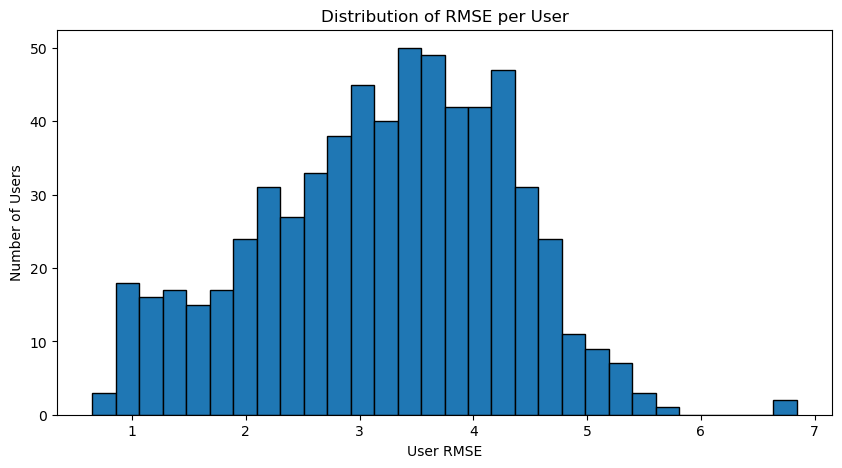

In [88]:
# Grouping predictions by user
user_preds = defaultdict(list)
for pred in predictions:
    user_preds[pred.uid].append(pred)

# Computing RMSE per user
user_rmses = []
for uid, preds in user_preds.items():
    true = np.array([p.r_ui for p in preds])
    est = np.array([p.est for p in preds])
    rmse = np.sqrt(np.mean((true - est) ** 2))
    user_rmses.append(rmse)

# Plotting histogram of user RMSEs
plt.figure(figsize=(10, 5))
plt.hist(user_rmses, bins=30, edgecolor='black')
plt.xlabel('User RMSE')
plt.ylabel('Number of Users')
plt.title('Distribution of RMSE per User')
plt.show()

This graph shows the **distribution of RMSE (Root Mean Squared Error) per user** for your recommendation model.

##### **What does this mean?**

- **X-axis (User RMSE):**  
  The RMSE value for individual users. Lower values mean the model’s predicted ratings are closer to the actual ratings for that user; higher values mean the predictions are less accurate.
- **Y-axis (Number of Users):**  
  The number of users who have a particular RMSE value.

##### **How to interpret this graph:**

- Most users have a RMSE between about **2 and 5**, with the highest concentration around **3 to 4**. This means that for most users, the model’s predictions are, on average, 3–4 rating points away from the actual ratings.
- There are a few users with very low RMSE (close to 1), meaning the model predicts their ratings very accurately.
- There are also a few users with higher RMSE (above 5), indicating the model struggles to predict ratings accurately for these users.
- The distribution is roughly bell-shaped but slightly right-skewed, suggesting that while the model works well for most users, there is a tail of users for whom prediction is more difficult.

##### **What can you learn from this?**

- **Consistency:** The model performs reasonably well for the majority of users, but not equally well for everyone.
- **Outliers:** Investigating users with high RMSE could reveal patterns (e.g., users with unusual tastes or little data) that might help you further improve your model.
- **Model quality:** If most RMSE values are low, your model is generally making accurate predictions.


**In summary:**  
This histogram helps you see how prediction accuracy varies across your user base, highlighting both the typical performance and the presence of users for whom the model may need improvement.

In [90]:
K = 10  # You can set K to any value you want

# Getting  top K recommendations for each user
def get_top_k(predictions, k=10):
    top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k[uid].append((iid, est, true_r))
    # Sort and keep top K for each user
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = user_ratings[:k]
    return top_k

top_k_recs = get_top_k(predictions, K)

# Building a mapping of relevant items for each user (e.g., true rating >= 4)
relevant = defaultdict(set)
for uid, iid, true_r, est, _ in predictions:
    if true_r >= 4:  # Adjust threshold as appropriate
        relevant[uid].add(iid)

# Calculating precision@K and recall@K for each user
precisions = []
recalls = []

for uid, user_recs in top_k_recs.items():
    recommended_iids = set([iid for iid, est, true_r in user_recs])
    relevant_iids = relevant[uid]
    n_rel_and_rec_k = len(recommended_iids & relevant_iids)
    n_rec_k = K
    n_rel = len(relevant_iids)

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
    recall = n_rel_and_rec_k / n_rel if n_rel else 0

    precisions.append(precision)
    recalls.append(recall)

# Averaging over all users
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print(f"Precision@{K}: {mean_precision:.3f}")
print(f"Recall@{K}: {mean_recall:.3f}")

Precision@10: 0.263
Recall@10: 0.522


#### **What does this tell you about your model?** 

**Precision@10 (0.263)**:Our recommendations are moderately accurate—about a quarter of our top 10 suggestions are hits. There’s room for improvement, but this is a reasonable starting point for many real-world recommenders, especially with large catalogs.

**Recall@10 (0.522)**:Our recommender is capturing over half of the items that users actually like in its top 10 suggestions. This means users are likely to see a good portion of the books they would enjoy.

Our model’s top 10 recommendations are moderately precise and capture a good portion of what users actually like. This is a solid baseline and a good sign that our recommender is providing value, but further tuning could improve both precision and recall!

#### **FCP: Fraction of Concordant Pairs**

##### **What does FCP measure?**

- **FCP** checks, for all possible pairs of items that a user has rated differently, whether the system’s predicted ranking matches the user’s true preference.
- A **concordant pair** is when both the user and the system agree on which item is preferred.
- A **discordant pair** is when the system’s ranking disagrees with the user’s actual preference.

##### **How is FCP calculated?**

$$
FCP = \frac{\text{Number of Concordant Pairs}}{\text{Number of Concordant Pairs} + \text{Number of Discordant Pairs}}
$$

- **Concordant pair:** If a user prefers item $i$ over item $j$ (e.g., rated higher), and the system also predicts a higher score for $i$ than $j$.
- **Discordant pair:** If the user prefers $i$ over $j$, but the system predicts $j$ over $i$.

**FCP ranges from 0 to 1:**
- **1** means perfect agreement between system and user preferences.
- **0** means no agreement.


##### **Why use FCP?**

- FCP focuses on the *relative ordering* of items, not just the absolute rating values.
- It is especially useful when the *ranking* of recommendations is more important than the exact predicted scores (such as in top-N recommendation lists).
- FCP provides granular insight into how well your system captures user preferences at the pairwise level[1].

In [92]:
print(f"FCP: {accuracy.fcp(predictions):.3f}")

FCP:  0.5013
FCP: 0.501


In this project, our goal is to generate a shortlist of 5–10 books that each user is most likely to enjoy, using a personalized book recommendation system built with Python and machine learning. To evaluate how well our model selects these top book recommendations, we focused on precision@k and recall@k, which directly measure how many of the books in each user's shortlist are actually relevant and how well we cover the set of books they would like.

While we also calculated the Fraction of Concordant Pairs (FCP), which measures the overall accuracy of item ranking across all possible book pairs, our observed FCP of approximately 0.501 suggests the model’s global ranking is only slightly better than random. However, because FCP considers all possible rankings and not just the top books presented to users, it is less informative for our specific objective of surfacing the best 5–10 book recommendations per user. For this reason, precision@k and recall@k remain the most useful metrics for guiding improvements to our book recommendation shortlist and ensuring users receive books they are likely to enjoy.

<a id="hybrid"></a>
## Hydrid Model 
[Back to Table of Contents](#TOC)

In [33]:
def hybrid_recommendation(
    df, collab_model, user_id=None, user_query=None, top_n=5, alpha=0.5, emb_col='Text_emb'
):
    """
    Generate hybrid book recommendations.
    
    Parameters:
        df: DataFrame with book metadata and embeddings
        collab_model: Trained collaborative filtering model
        user_id: (str) User ID, or None for new users
        user_query: (str) Book title or ISBN the user likes
        top_n: (int) Number of recommendations to return
        alpha: (float) Weight for collaborative filtering (0-1)
        emb_col: (str) Name of the embedding column to use (default 'Text_emb')
        
    Returns:
        DataFrame with top N recommendations
    """
    # Map title to ISBN if needed
    if not user_query:
        raise ValueError("Please provide a book title or ISBN as user_query.")
    if user_query in df['ISBN'].values:
        query_isbn = user_query
    else:
        match = df[df['Title'].str.lower() == user_query.lower()]
        if not match.empty:
            query_isbn = match.iloc[0]['ISBN']
        else:
            raise ValueError("Book not found in dataset.")

    # Content-based similarity
    query_vec = df.loc[df['ISBN'] == query_isbn, emb_col].values[0].reshape(1, -1)
    all_vecs = list(df[emb_col])
    cos_sims = cosine_similarity(query_vec, all_vecs).flatten()
    df['content_score'] = cos_sims

    # Collaborative filtering (if user_id provided)
    if user_id:
        df['collab_score'] = df['ISBN'].apply(lambda x: collab_model.predict(user_id, x).est)
    else:
        df['collab_score'] = 0

    # Normalize scores
    scaler = MinMaxScaler()
    df['content_score_norm'] = scaler.fit_transform(df[['content_score']])
    if user_id:
        df['collab_score_norm'] = scaler.fit_transform(df[['collab_score']])
    else:
        df['collab_score_norm'] = 0

    # Hybrid score
    df['hybrid_score'] = alpha * df['collab_score_norm'] + (1 - alpha) * df['content_score_norm']

    # Show top recommendations
    result = df.sort_values('hybrid_score', ascending=False)
    return result[['Title', 'Author', 'Genre', 'hybrid_score']].head(top_n)


In [45]:
import pickle
from surprise import dump

# Load DataFrame
with open('../models/book_title_embeddings_updated.pkl', 'rb') as f:
    df = pickle.load(f)

# Load collaborative model
_, collab_model = dump.load('../models/funkSVD_model.pkl')

In [47]:
# Now you can call your recommendation function
hybrid_recommendation(df, collab_model, user_id=None, user_query="The Hobbit", top_n=7, alpha=0.5)

,Title,Author,Genre,hybrid_score
1242,The Hobbit,J R R Tolkien,"Arkenstone, Battle of Five Armies, invisibility",0.500000
5866,The Hobbit (Leatherette Collector's Edition),J. R. R. Tolkien,"Arkenstone, Battle of Five Armies, invisibility",0.425407
8474,"The Hobbit (Young Adult edition, Sis cover)",J. R. R. Tolkien,"Arkenstone, Battle of Five Armies, invisibility",0.425407
3532,The Lord of the Rings,J. R. R. Tolkien,"The Lord of the Rings, Fiction, Ficción",0.383867
8799,The Return of the King,J. R. R. Tolkien,"Elves, Hobbits, The Lord of the Rings",0.375115
4797,"The Return of the King (The Lord of The Rings, Part 3)",J. R. R. Tolkien,"Elves, Hobbits, The Lord of the Rings",0.375115
3065,The Hobbit: Or There and Back Again,J. R. R. Tolkien,"Arkenstone, Battle of Five Armies, invisibility",0.373720


In [44]:
# For a returning user (hybrid)
hybrid_recommendation(df, collab_model, user_id='8', user_query="The Hobbit", top_n=10, alpha=0.5)

,Title,Author,Genre,hybrid_score
2166,The Blue Day Book,Bradley Trevor Greive,"Melancholy, Conduct of life, Miscellanea",0.745484
1279,"The Lion, the Witch, and the Wardrobe (The Chronicles of Narnia, Book 2)",C. S. Lewis,"the Blitz, fauns, Turkish Delight",0.732695
1456,Griffin &amp; Sabine: An Extraordinary Correspondence,Nick Bantock,"Imaginary letters, Toy and movable books, Specimens",0.716880
140,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,"Ghosts, Monsters, Vampires",0.677039
137,The Hobbit : The Enchanting Prelude to The Lord of the Rings,J.R.R. TOLKIEN,"Arkenstone, Battle of Five Armies, invisibility",0.660661
87,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,"Children's Books/Ages 9-12 Fiction, Witches and warlocks, Juvenile audience",0.656387
59,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,"Fantasy fiction, orphans, foster homes",0.637233
1151,The Two Dead Girls (Green Mile Series),Stephen King,"horror fiction, fiction, death row inmates",0.631708
976,Mama Makes Up Her Mind: And Other Dangers of Southern Living,Bailey White,"Social life and customs, Humor, Large type books",0.623541
3565,"Hound Of The Far Side (Far Side Books, Collection No 7)",Gary Larson,"Pictorial American wit and humor, Graphic novels, Comics and cartoons",0.620138
